# GPU COMputing with Python

## I - Analysis of Discrete Probabilities,
### based on the Number of jobs on the SSC queue


In [349]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
partition_list = [ "medium", "gpu", "fat", "fat+", "int"]
minGB_head = [
    "Partition", "< 4 GBh", "4 GBh -  256 GBh", "256 GBh - 512 GBh",
    "512 GBh - 1024 GBh", "1024 GBh - 2048 GBh", "> 2048 GBh"]

def sacct(output):
    process = subprocess.run([
        "python", "gpu.py", "-m",
        "-t", output],
        stdout=subprocess.PIPE, shell=False)
    decode = process.stdout.decode('utf-8').splitlines()[-5:]
    decode = [i.split('  ') for i in decode]
    for k in decode:
        s = ''
        while s in k:
            k.pop(k.index(s))
    frame = pd.DataFrame(decode, 
                         columns = minGB_head)
    return frame
origin = sacct('slurm_output0')
origin

,Partition,< 4 GBh,4 GBh - 256 GBh,256 GBh - 512 GBh,512 GBh - 1024 GBh,1024 GBh - 2048 GBh,> 2048 GBh
0,medium,14.3 m (5943),1.2 h (60363),3.4 h (4546),21.4 h (7416),7.7 h (2104),9.4 h (1332)
1,gpu,3.7 s (238),5.2 h (489),1.1 h (130),8.1 m (14),2.4 h (76),6.1 h (128)
2,fat,2.8 s (5),7.4 h (2708),2242.5 d (164),18.2 m (44),3.1 m (93),2.1 h (209)
3,fat+,NA,NA,NA,NA,NA,21.9 m (16)
4,int,NA,1.2 s (81),6.3 m (56),35.0 m (1),2.8 s (29),NA


In [350]:
def beautiful(daframe):
    dat = daframe.T.T.T
    dat.columns = [ "medium", "gpu", "fat", "fat+", "int"]
    dat = dat[1:]
    return dat
dat = beautiful(origin)
dat

,medium,gpu,fat,fat+,int
< 4 GBh,14.3 m (5943),3.7 s (238),2.8 s (5),NA,NA
4 GBh - 256 GBh,1.2 h (60363),5.2 h (489),7.4 h (2708),NA,1.2 s (81)
256 GBh - 512 GBh,3.4 h (4546),1.1 h (130),2242.5 d (164),NA,6.3 m (56)
512 GBh - 1024 GBh,21.4 h (7416),8.1 m (14),18.2 m (44),NA,35.0 m (1)
1024 GBh - 2048 GBh,7.7 h (2104),2.4 h (76),3.1 m (93),NA,2.8 s (29)
> 2048 GBh,9.4 h (1332),6.1 h (128),2.1 h (209),21.9 m (16),NA


In [351]:
for k in dat:
    print(k)

medium
gpu
fat
fat+
int


In [352]:
dat[['gpu']]

,gpu
< 4 GBh,3.7 s (238)
4 GBh - 256 GBh,5.2 h (489)
256 GBh - 512 GBh,1.1 h (130)
512 GBh - 1024 GBh,8.1 m (14)
1024 GBh - 2048 GBh,2.4 h (76)
> 2048 GBh,6.1 h (128)


In [353]:
#print(dat.loc['gpu'][['< 4 GBh']])
data_frequencies = dat.copy(deep = True)
for partition in dat.index:
    #data_frequencies.loc[partition]['Mean'] = mean(data_frequencies.loc[partition])
    for  volum in dat.columns:
        if '(' in str(data_frequencies.loc[partition][[volum]]):
            data_frequencies.loc[partition][[volum]] = int(str(data_frequencies.loc[partition][[volum]]).split('(')[1].split(')')[0])
        else:
            data_frequencies.loc[partition][[volum]] = np.NaN
            continue
            
dic = {ind: [] for ind in data_frequencies.T.index}
for partition in data_frequencies.T.index:
    dic[partition].append(round(np.mean(data_frequencies.T.loc[partition].dropna()), 2))

for name in dic:
    value = dic[name][0]
    dic[name] = value
print(dic)
data_frequencies.loc['means'] = dic
data_frequencies 

{'medium': 13617.33, 'gpu': 179.17, 'fat': 537.17, 'fat+': 16.0, 'int': 41.75}


,medium,gpu,fat,fat+,int
< 4 GBh,5943,238,5,NaN,NaN
4 GBh - 256 GBh,60363,489,2708,NaN,81
256 GBh - 512 GBh,4546,130,164,NaN,56
512 GBh - 1024 GBh,7416,14,44,NaN,1
1024 GBh - 2048 GBh,2104,76,93,NaN,29
> 2048 GBh,1332,128,209,16,NaN
means,13617.33,179.17,537.17,16.0,41.75


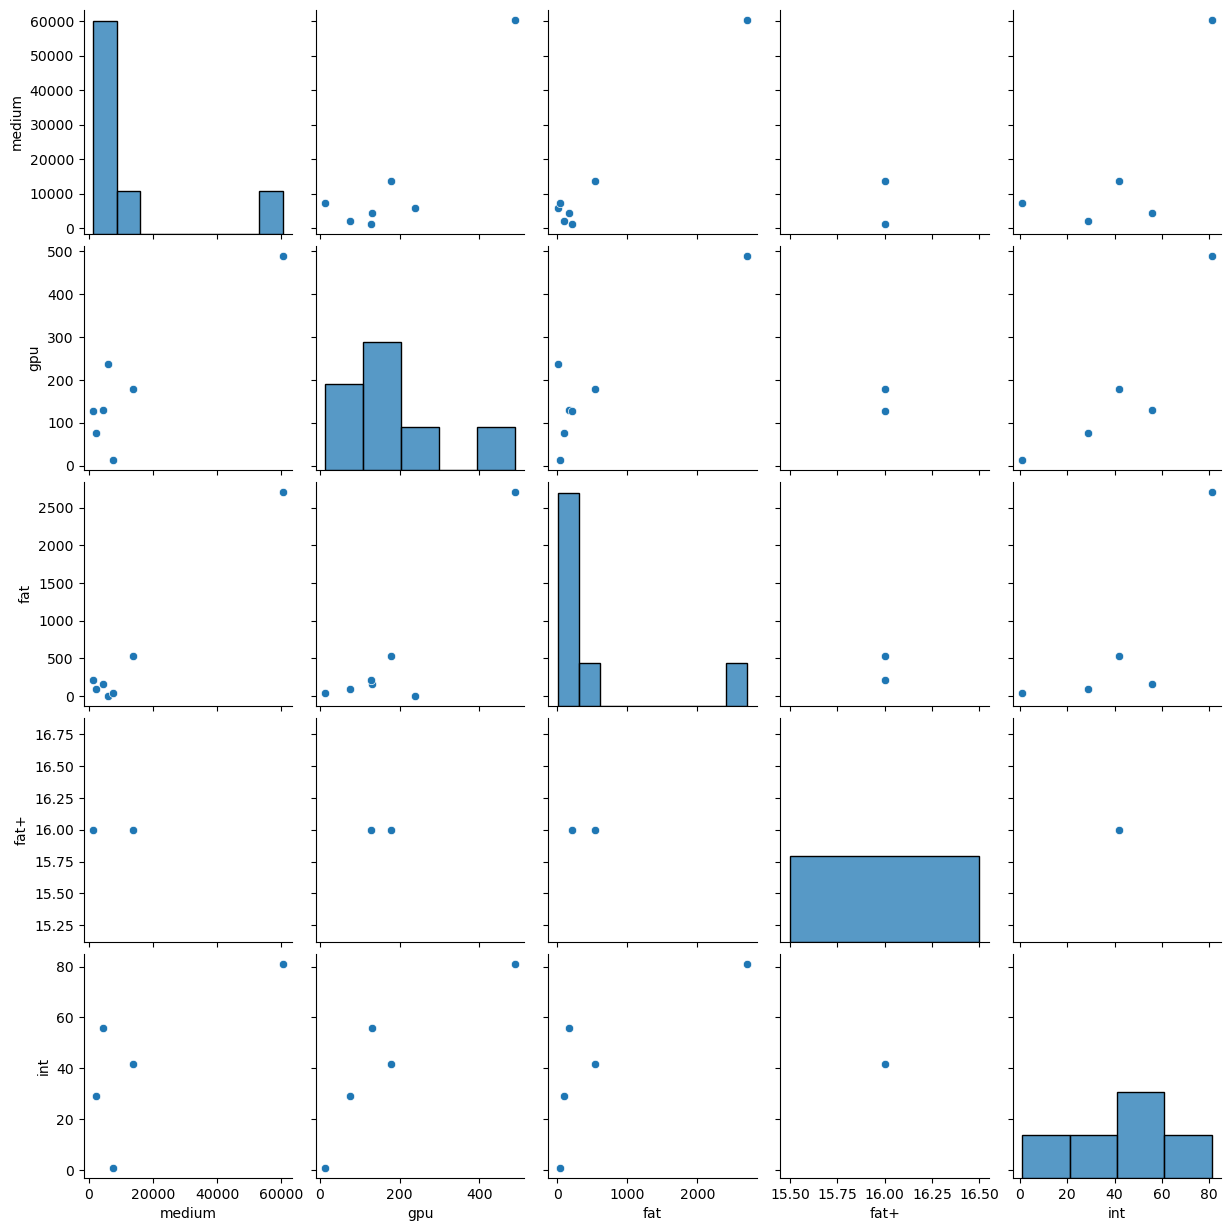

In [354]:
sns.pairplot(data_frequencies)

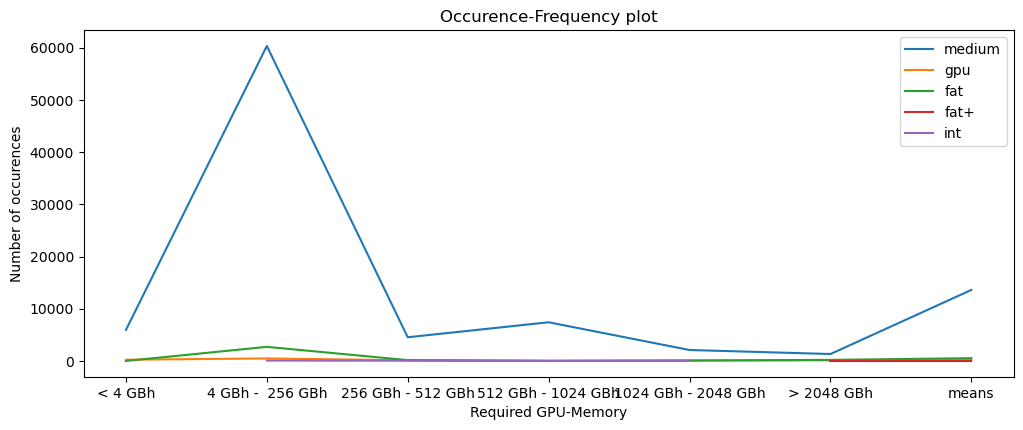

In [355]:
ax = data_frequencies.plot(title = 'Occurence-Frequency plot', xlabel = 'Required GPU-Memory', ylabel = 'Number of occurences', figsize = (12, 4.5))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

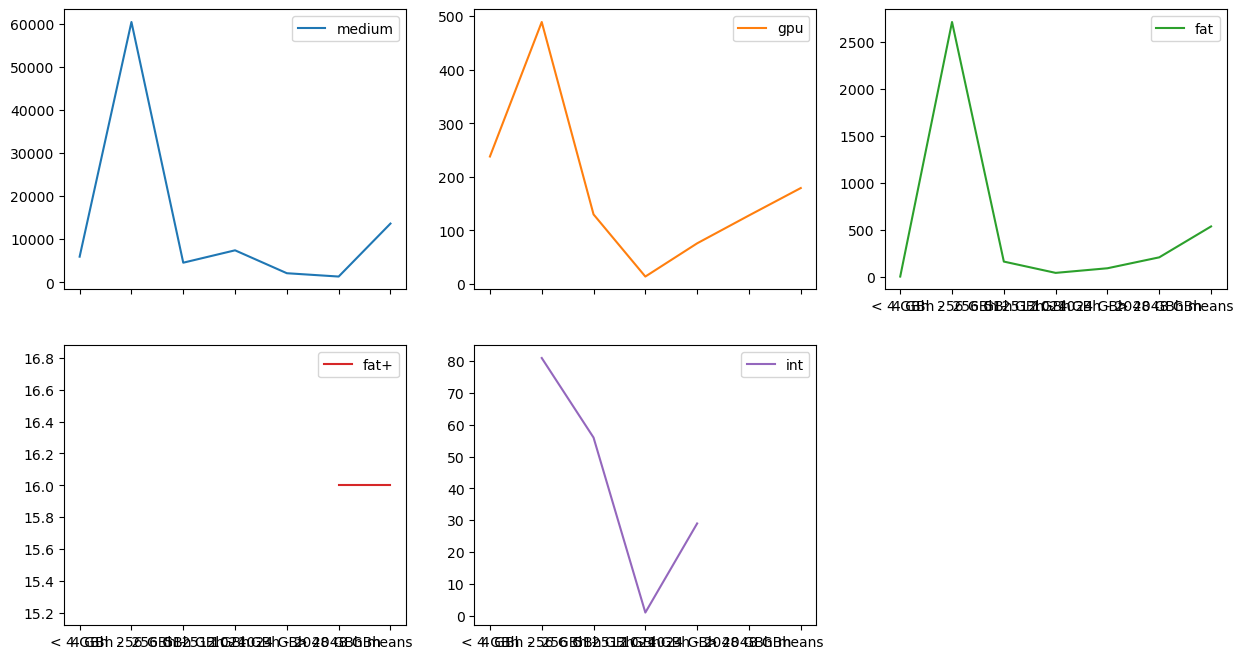

In [356]:
data_frequencies.plot(subplots=True, figsize=(15, 8), layout=(2, 3))

In [357]:
def convert_to_seconds(val, unit):
    rule0 = ['s', 'm', 'h', 'd', 'w']
    rule1 = [1, 60, 60*60, 60*60*24, 60*60*24*7]
    ind = rule0.index(unit)
    val_in_sec = val * rule1[ind]
    return val_in_sec

In [358]:
dat_in_sec = dat.copy(deep = True)
for partition in dat.index:
    for  volum in dat.columns:
        if '(' in str(dat_in_sec.loc[partition][[volum]]):
            val = float(str(dat_in_sec.loc[partition][[volum]]).split('(')[0][:-1].split(' ')[-2])
            unit = str(dat_in_sec.loc[partition][[volum]]).split('(')[0][:-1].split(' ')[-1]
            dat_in_sec.loc[partition][[volum]] = convert_to_seconds(val, unit)
        else:
            dat_in_sec.loc[partition][[volum]] = np.NaN
            continue
            
dic = {ind: [] for ind in dat_in_sec.T.index}
for partition in dat_in_sec.T.index:
    print(np.mean(dat_in_sec.T.loc[partition].dropna()))
    dic[partition].append(round(np.mean(dat_in_sec.T.loc[partition].dropna()), 2))

for name in dic:
    value = dic[name][0]
    dic[name] = value
dat_in_sec.loc['means'] = dic
dat_in_sec 

26003.0
8961.616666666667
32297913.46666667
1314.0
620.5


,medium,gpu,fat,fat+,int
< 4 GBh,858.0,3.7,2.8,NaN,NaN
4 GBh - 256 GBh,4320.0,18720.0,26640.0,NaN,1.2
256 GBh - 512 GBh,12240.0,3960.0,193752000.0,NaN,378.0
512 GBh - 1024 GBh,77040.0,486.0,1092.0,NaN,2100.0
1024 GBh - 2048 GBh,27720.0,8640.0,186.0,NaN,2.8
> 2048 GBh,33840.0,21960.0,7560.0,1314.0,NaN
means,26003.0,8961.62,32297913.47,1314.0,620.5


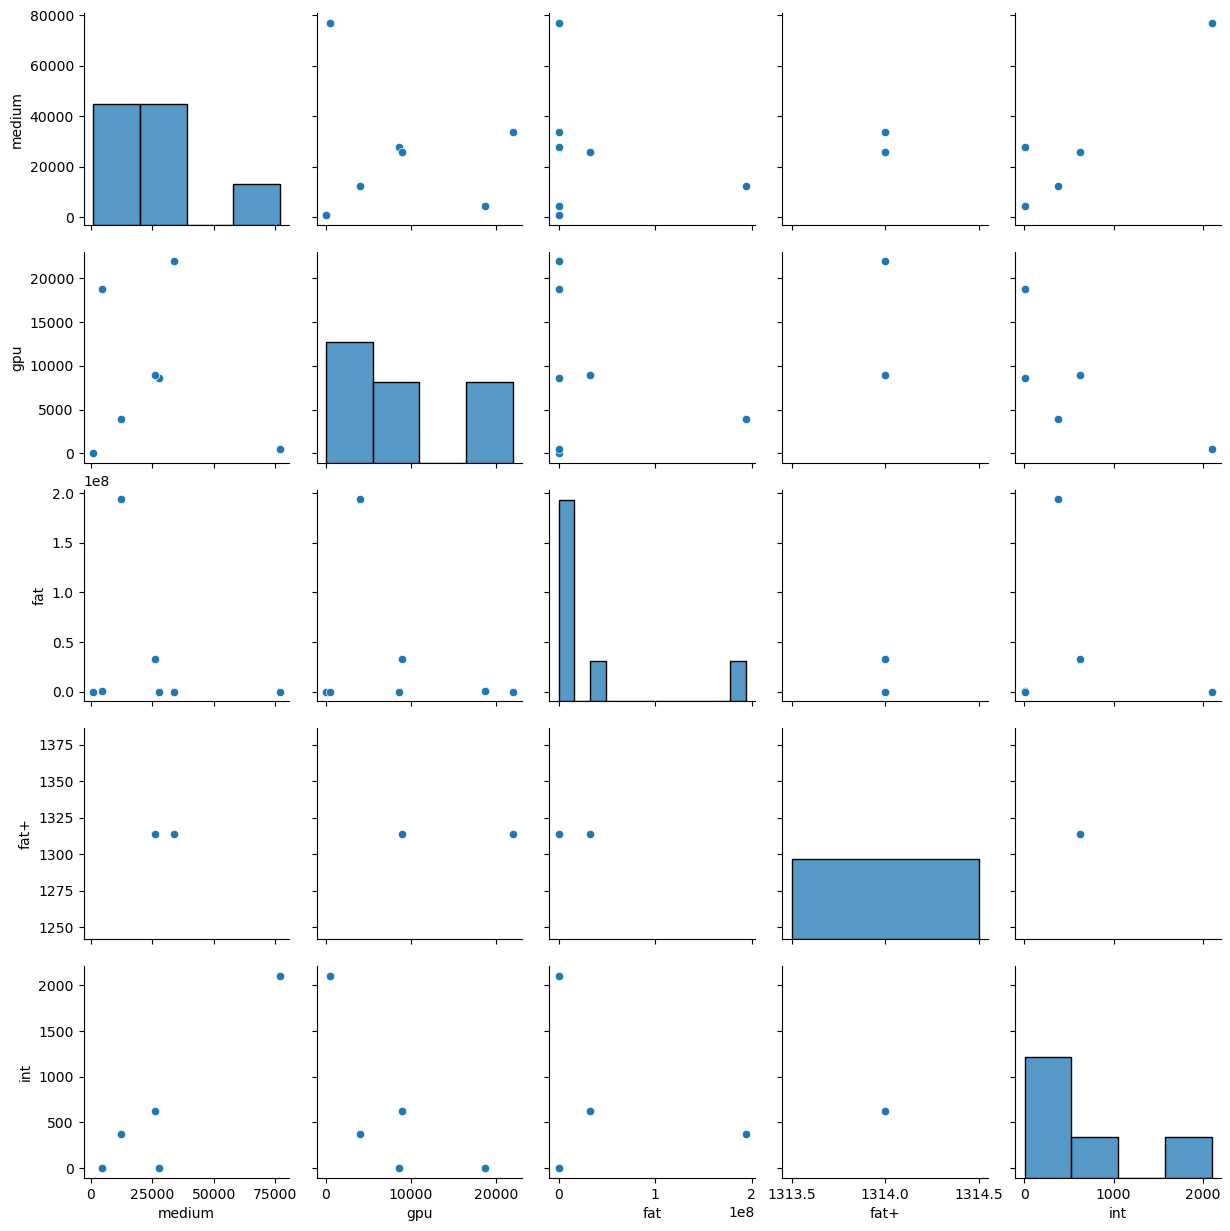

In [359]:
sns.pairplot(dat_in_sec)

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

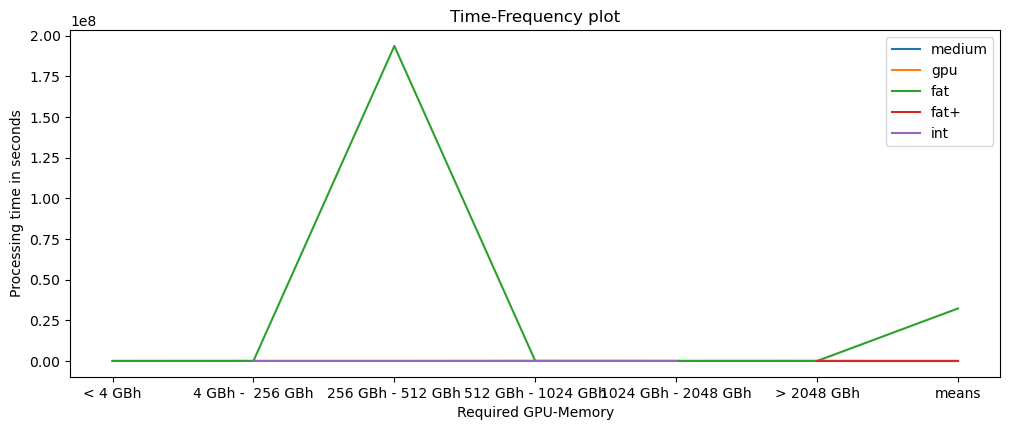

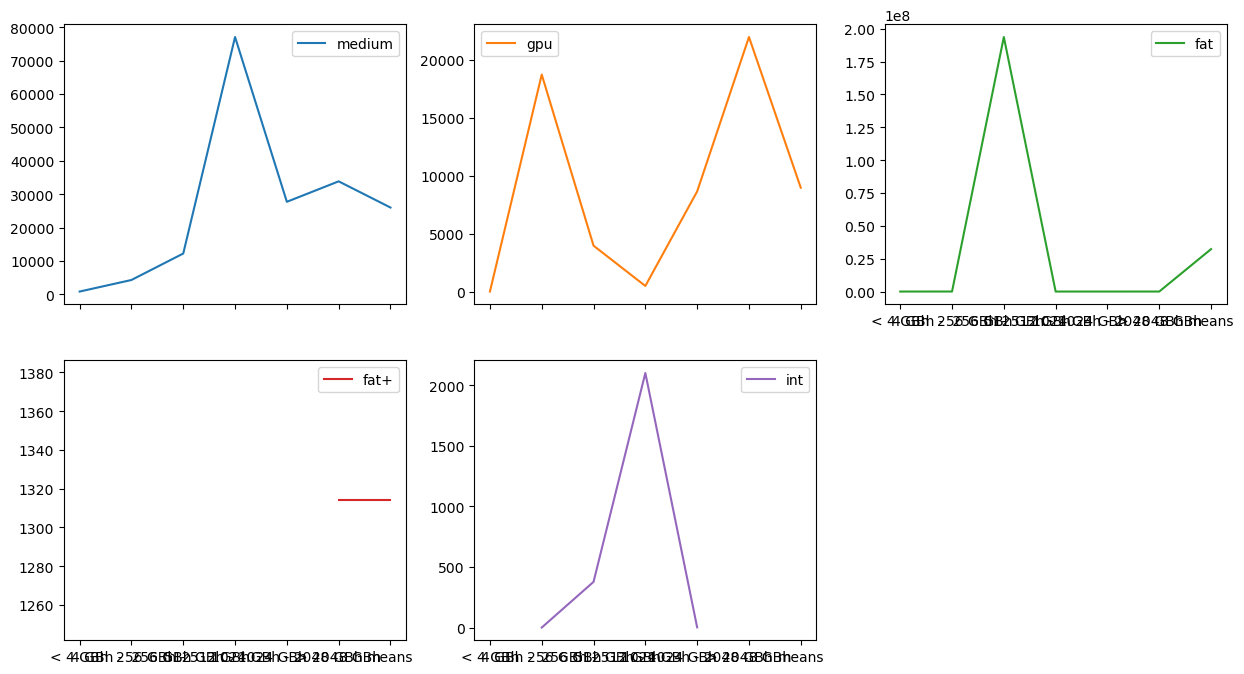

In [360]:
ax = dat_in_sec.plot(title = 'Time-Frequency plot', xlabel = 'Required GPU-Memory', ylabel = 'Processing time in seconds', figsize = (12, 4.5))
dat_in_sec.plot(subplots=True, figsize=(15, 8), layout=(2, 3))

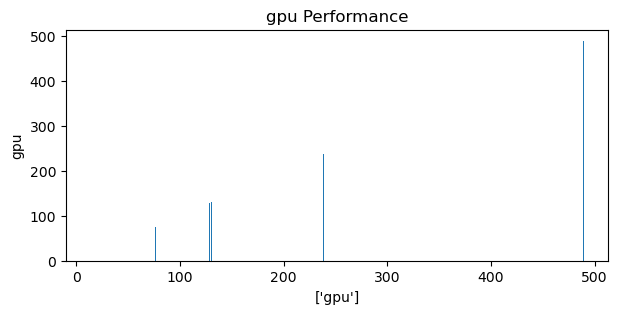

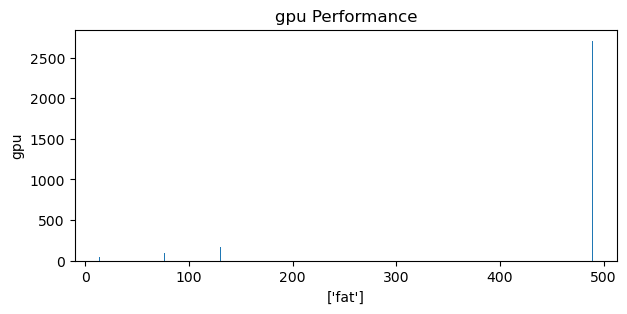

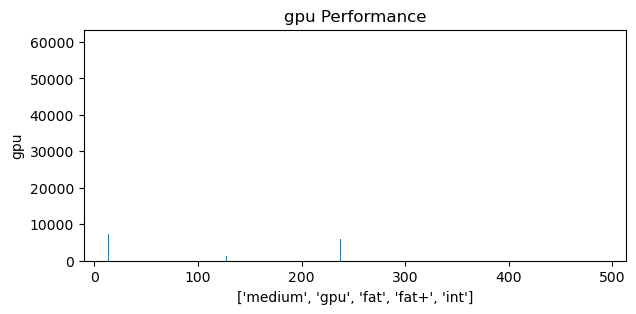

      0      1     2     3     4     5
0  5943  60363  4546  7416  2104  1332
1   238    489   130    14    76   128
2     5   2708   164    44    93   209
3     0      0     0     0     0    16
4     0     81    56     1    29     0
(5, 6)
(5, 2)
[[ 0.40835057  0.40868815  0.40874575  0.40846421  0.40877801  0.40645818]
 [-0.30325707 -0.04871906 -0.13180605 -0.3244496  -0.06950055  0.88215129]]


,< 4 GBh,4 GBh - 256 GBh,256 GBh - 512 GBh,512 GBh - 1024 GBh,1024 GBh - 2048 GBh,> 2048 GBh
0,0.408351,0.408688,0.408746,0.408464,0.408778,0.406458
1,-0.303257,-0.048719,-0.131806,-0.324450,-0.069501,0.882151


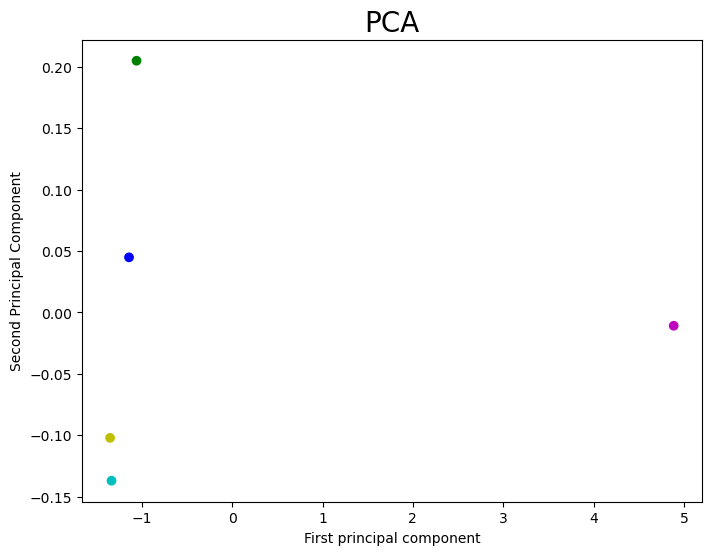

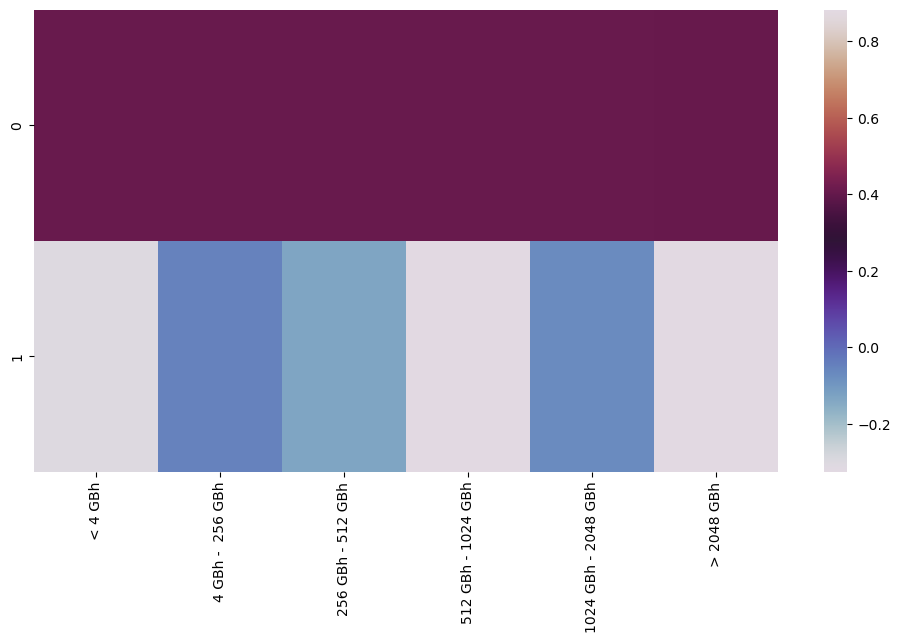

In [361]:
# Explaimed variance and PCA

# Explained Variance Visualization I
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def balken1(data, partition='gpu'):
    %matplotlib inline
    plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':100})
    dat_=data.replace(["NA"], "0 o (0)")
    dat_=dat_.replace([" NA"], "0 o (0)")
    X = [eval(j) for j in [str(g).split('(')[1].split(')')[0] for g in dat_['gpu'].values]]
    Y = [eval(i) for i in [str(g).split('(')[1].split(')')[0] for g in dat_[partition].values]]
    Z = [eval(j) for j in [str(g).split('(')[1].split(')')[0] for g in dat_[partition_list].values]]
    plt.bar(X,Y)
    plt.xlabel(partition)
    plt.ylabel("gpu")
    plt.title('gpu Performance')
    plt.show()
balken1(dat, [ 'gpu'])
balken1(dat, [ 'fat'])
#balken1(dat, [ 'fat+'])
balken1(dat, partition_list)


# PCA Visualization II
def balken2(data, partition):
  #  dat_ = data.replace('NA',0)
  #  print(dat_)
    if 'NA' not in data[partition].values:
        heights = [eval(j) for j in [str(g).split('(')[1].split(')')[0] for g in data[partition].values]]
    else:
        daz=data.replace(["NA"], "0 o (0)")
        daz=daz.replace([" NA"], "0 o (0)")
        heights = [eval(j) for j in [str(g).split('(')[1].split(')')[0] for g in daz[partition].values]]
    return heights
Heights = [balken2(dat, i) for i in partition_list]
Heights = pd.DataFrame(Heights)
print(Heights)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Heights)
scaled_data = scaler.transform(Heights)
scaled_data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaled_data)
print(scaled_data.shape)
x_pca = pca.transform(scaled_data)
x_pca
print(x_pca.shape)
plt.figure(figsize=(8,6))
targets = ['Benign', 'Malignant']
colors = ['m', 'b', 'g','y','c']
plt.scatter(x_pca[:,0],x_pca[:,1],c=colors,cmap='rainbow',label=partition_list)
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title("PCA",fontsize=20)
print(pca.components_)
map= pd.DataFrame(pca.components_,columns=minGB_head[1:])
plt.figure(figsize=(12,6))
sns.heatmap(map,cmap='twilight')
map